In [6]:
import requests
import json
import logs as l
import sentence_transformers
from matplotlib import pyplot as plt
import seaborn as sns

TARGET_URL = "http://localhost:5000"
REQUEST_URL = f"{TARGET_URL}/request"
VOCAB_URL = f"{TARGET_URL}/vocab"
headers = {
    "Content-Type": "application/json",
    "Connection": "keep-alive",

}

prompt_math = "What is 14+5*34?"
prompt_explain = "Explain the concept of a derivative."
prompt_weather = "What is the weather likely to be in December?"
prompt_summary = """Summarise the following lines: Countries worldwide are designing and implementing AI governance legislation and policies commensurate to the velocity and variety of proliferating AI-powered technologies. Efforts include the development of comprehensive legislation, focused legislation for specific use cases, national AI strategies or policies, and voluntary guidelines and standards. There is no standard approach toward bringing AI under state regulation, however, common patterns toward reaching the goal of AI regulation can be observed. Given the transformative nature of AI technology, the challenge for jurisdictions is to find a balance between innovation and regulation of risks. Therefore, governance of AI often, if not always, begins with a jurisdiction rolling out a national strategy or ethics policy instead of legislating from the get-go.

This pattern is evident throughout this tracker. The tracker identifies legislative or policy developments or both in a subset of jurisdictions. Such initiatives are either already being deliberated at the country level or are in the process of commencing deliberations in countries across six continents, speaking to the global importance of AI. However, given the rapid and widespread policymaking in this space, the tracker does not include all AI initiatives within every jurisdiction across every continent. This tracker also offers brief commentary on the broader AI context and related developments and identifies laws or policies in parallel professions like privacy.

As individual jurisdictions press ahead with their own frameworks and approaches, they have also doubled down on multilateral efforts to coordinate and cohere different approaches. The Organisation for Economic Co-operation and Development's AI principles have been reaffirmed in many different contexts, including by digital and technology ministers of the G7 countries during the 2023 Hiroshima Summit. UNESCO, the International Organization for Standardization, the African Union and the Council of Europe are all working on multilateral AI governance frameworks. The U.K. government organized the first AI Safety Summit in 2023 for government and industry stakeholders to agree upon, evaluate and monitor the most significant risks from AI.

Tracking, unpacking and governing the complex field of global AI governance law and policy has quickly become a top-tier strategic issue for organizations. The IAPP AI Governance Center will continue to provide AI governance professionals with the content, resources, networking, training and certification needed to respond to the field's complex risks. The IAPP AI Global Law and Policy Tracker has been updated with valuable input from the global community of AI governance professionals, and we continue to welcome feedback and insights from this community."""

question = prompt_summary

vocab = requests.get(VOCAB_URL).json()
VOCAB_LEN = len(vocab.keys())
rev_vocab = {v:k for k,v in vocab.items()}


In [7]:
def build_data(question):
    return {
    "prompt": [{"role":"user", "content":question}],
    "process_logits": True,
    "run_config": {"do_sample": True,
    "debug_mode": True}
    }

def build_reflection(question, response):
    return {
    "prompt": [ {"role":"user", "content":f"The user asked: {question} Answer: {response}. Reflect and improve the response and fix any errors."}],
    "process_logits": True,
    "run_config": {"do_sample": True,
    "debug_mode": True}
}

def get_response(_response):
    return _response.get("response")[1].get("content")

def calculate_similarity(original:str, reflection:str) -> float:
    orig = get_response(original)
    ref = get_response(reflection)

    model = sentence_transformers.SentenceTransformer('paraphrase-MiniLM-L6-v2')
    orig_vec = model.encode(orig)
    ref_vec = model.encode(ref)
    return sentence_transformers.util.pytorch_cos_sim(orig_vec, ref_vec)

def create_logits_frequency(logits):
    fingerprint = {k:0 for k in rev_vocab.keys()}
    validate = len(logits[-1][0])
    for logit in logits[-1][0]:
        fingerprint[logit] = fingerprint.get(logit,0) + 1

    total = sum(fingerprint.values())
    assert total == validate
    print(f"Total tokens: {total}") 
    return fingerprint

def filter_non_zero(token_frequency):
    return {k:v for k,v in token_frequency.items() if v > 0}

def compare_logit_frequency(original, reflection):
    delta = {}
    common_token_by_frequency = []

    for k,vo in original.items():
        vr = reflection.get(k)

        if vr == None:
            print(f"Token {k} not found in reflection")

        if vo == vr == 0:
            continue
       
        delta[k] = vo-vr
        if vo-vr == 0:
            common_token_by_frequency.append(k)

    return delta, common_token_by_frequency
 
similarities = []
deltas = []

In [8]:

for i in range(10):

    print(f"Sent {i}")

    original = requests.post(REQUEST_URL, data=json.dumps(build_data(question)), headers=headers).json()
    orig_fing = create_logits_frequency(original.get("logits"))
    print("Original response:")
    try:
        l.log_info(get_response(original), "original")
    except:
        pass

    reflection = build_reflection(question, get_response(original))
    reflection_resp = requests.post(REQUEST_URL, data=json.dumps(build_data(question)), headers=headers).json()
    ref_fing = create_logits_frequency(reflection_resp.get("logits"))
    print("Reflected response:")
    try:
        l.log_info(get_response(reflection_resp), "reflected")
    except:
        pass
    
    similarity = calculate_similarity(original, reflection_resp)
    similarities.append(similarity.item())
    delta, common_tokens = compare_logit_frequency(orig_fing, ref_fing)
    deltas.append(delta)
    l.log_info(similarity.item(), "similarity")



Sent 0
Total tokens: 905
Original response:
Total tokens: 821
Reflected response:
Sent 1
Total tokens: 898
Original response:
Total tokens: 747
Reflected response:
Sent 2
Total tokens: 803
Original response:
Total tokens: 867
Reflected response:
Sent 3
Total tokens: 794
Original response:
Total tokens: 796
Reflected response:
Sent 4
Total tokens: 917
Original response:
Total tokens: 848
Reflected response:
Sent 5
Total tokens: 923
Original response:
Total tokens: 935
Reflected response:
Sent 6
Total tokens: 739
Original response:
Total tokens: 957
Reflected response:
Sent 7
Total tokens: 1012
Original response:
Total tokens: 948
Reflected response:
Sent 8
Total tokens: 979
Original response:
Total tokens: 886
Reflected response:
Sent 9
Total tokens: 956
Original response:
Total tokens: 1001
Reflected response:


0.9110515713691711
0.8626396656036377
0.8631806969642639
0.9392111301422119
0.9348848462104797
0.945955216884613
0.8478005528450012
0.8831748962402344
0.9049242734909058
0.903986394405365


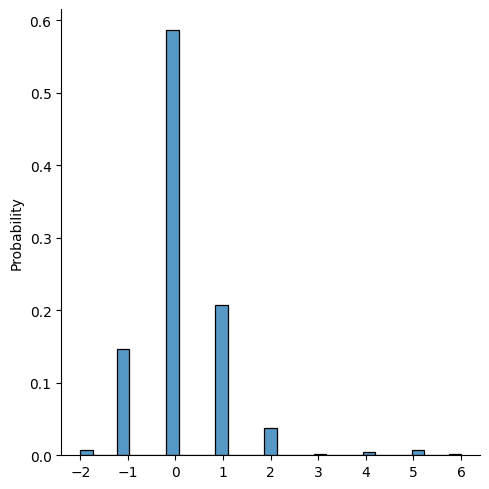

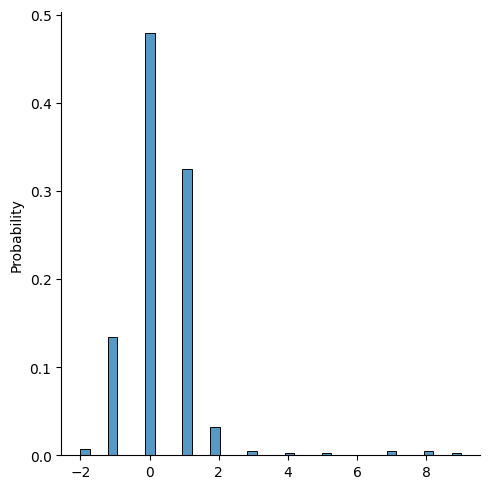

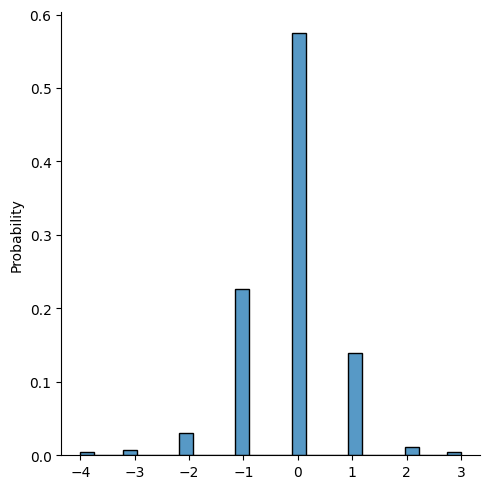

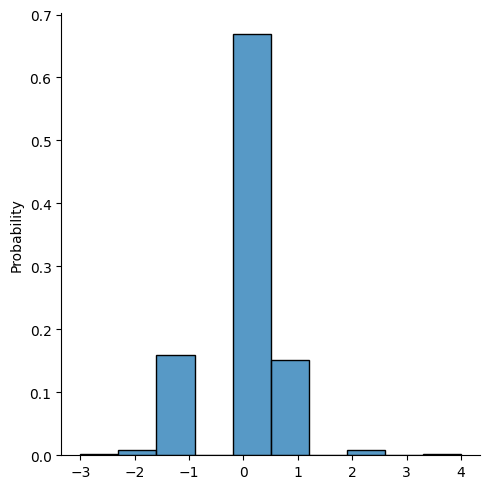

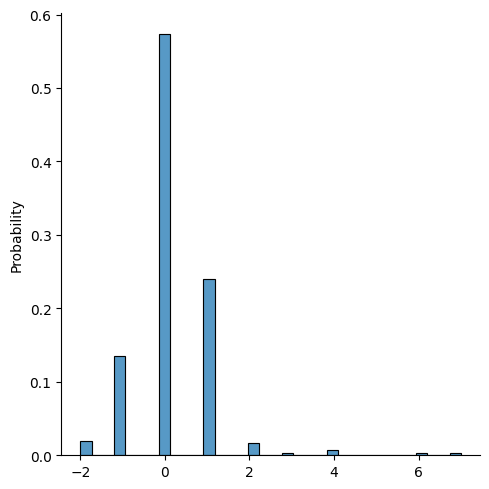

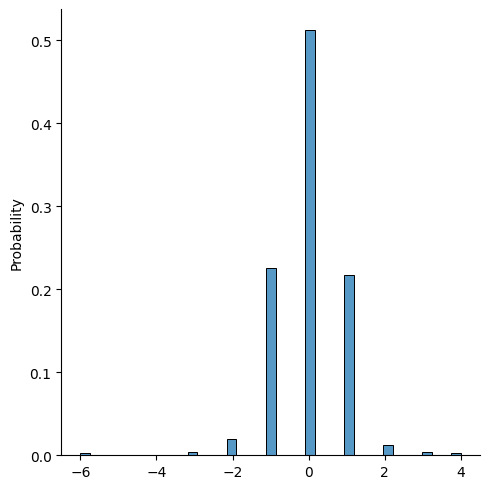

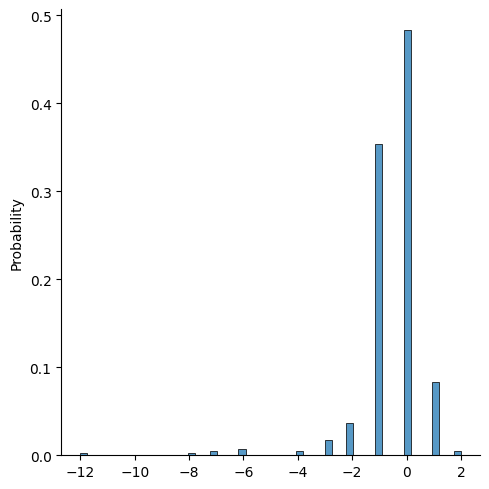

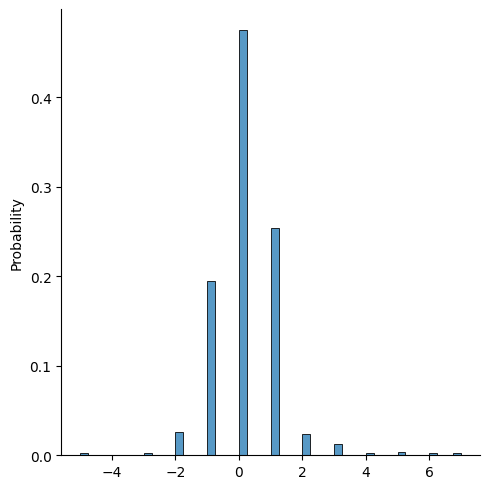

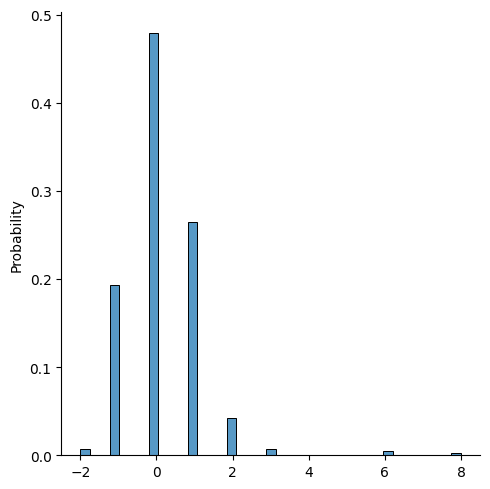

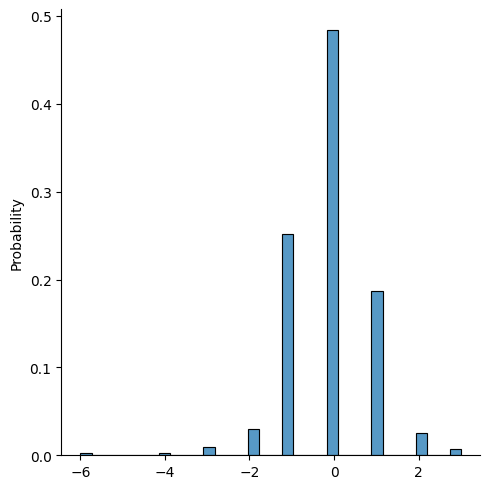

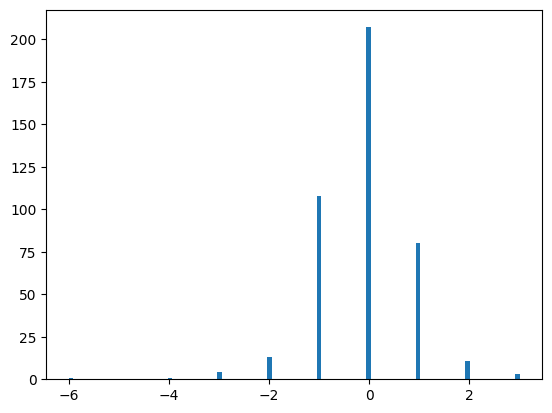

Common tokens: [':', '<0x0A>', '<|assistant|>', '<|end|>', '<|user|>', 'APP', 'As', 'CO', 'ES', 'I', 'Track', 'acy', 'als', 'ary', 'ative', 'd', 'diction', 'encing', 'ens', 'ensive', 'ents', 'er', 'ere', 'essions', 'ff', 'go', 'ic', 'ics', 'idel', 'ides', 'ier', 'ifer', 'ifies', 'ights', 'ima', 'ines', 'ing', 'iro', 'ise', 'ization', 'l', 'mar', 'ning', 'ologies', 'on', 'operation', 'ort', 'p', 'pack', 'read', 'ries', 's', 'sh', 'ur', '▁A', '▁African', '▁Center', '▁Co', '▁Council', '▁Count', '▁Development', '▁E', '▁Econom', '▁Europe', '▁Global', '▁H', '▁However', '▁I', '▁International', '▁Law', '▁Organ', '▁Organisation', '▁Policy', '▁Standard', '▁Such', '▁The', '▁There', '▁Therefore', '▁Tra', '▁UN', '▁Union', '▁agree', '▁ahead', '▁already', '▁also', '▁always', '▁approaches', '▁as', '▁at', '▁be', '▁begins', '▁being', '▁between', '▁brief', '▁bringing', '▁can', '▁coh', '▁comm', '▁comment', '▁community', '▁complexity', '▁compreh', '▁content', '▁contin', '▁coordinate', '▁design', '▁digital'

In [9]:


for i, d in enumerate(deltas):
    sns.displot(d, stat='probability')
    print(similarities[i])
plt.show()

plt.hist(delta.values(), bins=100)
plt.show()

print(f"Common tokens: {[rev_vocab[c] for c in common_tokens]}")
print(similarities)
